In [9]:
import asyncio
import sys
from functools import wraps
from typing import Awaitable, Callable

import evaluate
import pandas as pd
import plotly.io
from litellm import acompletion, completion_cost
from pydantic import BaseModel
from tqdm.asyncio import tqdm

sys.path.append("../..")

from climateguard.evaluation import evaluation_report

plotly.io.renderers.default = "png"

In [10]:
# Load the synthetic Mediatree benchmark and take a small sample for quick iteration
df = pd.read_csv("../../data/benchmark/mediatree_synthetic_sample_1000.csv")
df = df.sample(100, random_state=42)
display(df)
display(df["is_contrarian"].value_counts())

,text,claim,is_contrarian,label,source
213,de câbles qui vont être concentrés dans un rés...,"Cependant, il est bon de se rappeler que la sc...",True,5_science_is_unreliable,europe1
331,l' environnement le scientifique est mort à l'...,"Cependant, il convient de noter que certains a...",True,3_its_not_bad,france-info
501,Sait que les gens nous exigent de ses cendres ...,Certains affirment que l'impact du CO2 sur le ...,True,2_its_not_us,france24
309,illustrant tous les deux arnaud teyssier votre...,NaN,False,0_accepted,france-culture
88,deliveroo toutes les adresses à votre porte mê...,NaN,False,0_accepted,bfmtv
...,...,...,...,...,...
545,de civilisation américaine à l' université sor...,NaN,False,0_accepted,france24
86,On assume la transition écologique un peu tout...,"Cependant, certains affirment que les impacts ...",True,3_its_not_bad,bfmtv
644,emmanuel macron a annoncé tout à l' heure l' e...,NaN,False,0_accepted,lci
158,pas alors il faut savoir que je vous donne un ...,NaN,False,0_accepted,d8


is_contrarian
True     52
False    48
Name: count, dtype: int64

In [11]:
# Fixing some syntax issues in the data

# Mediatree issue with "' "
df["text"] = df["text"].str.replace("' ", "'")

# Remove punctuation that is only present in synthetic texts to avoid bias
df["text"] = df["text"].str.replace(".", "").str.replace(",", "")

# Remove casing that is mostly present in synthetic texts to avoid bias
df["text"] = df["text"].str.lower()

In [12]:
class MediatreePrediction(BaseModel):
    cards_label_pred: str
    prompt_tokens: int
    completion_tokens: int
    total_tokens: int
    cost: float
    claim_pred: str | None = None


async def report_experiment_results(
    df: pd.DataFrame, predict_experiment: Callable[[str], Awaitable[None]]
) -> None:
    # Copy df to avoid modifications
    df = df.copy()

    # Run the experiment
    mediatree_predictions: list[MediatreePrediction] = await tqdm.gather(
        *[predict_experiment(text) for text in df["text"]]
    )
    mediatree_predictions_df = pd.DataFrame(
        [pred.model_dump(exclude_none=True) for pred in mediatree_predictions],
        index=df.index,
    )
    df = pd.concat([df, mediatree_predictions_df], axis=1)

    # Show stats and performance
    show_llm_usage(df)
    evaluation_report(df["label"], df["cards_label_pred"])
    if "claim_pred" in df.columns:
        show_claim_extraction_quality_evaluation(df)


def show_llm_usage(df: pd.DataFrame) -> None:
    print("\nLLM USAGE\n=========\n")
    print(
        f"Median token usage:\n- Prompt: {int(df["prompt_tokens"].median())}\n"
        f"- Completion: {int(df["completion_tokens"].median())}\n"
        f"- Total: {int(df["total_tokens"].median())}"
    )
    print(f"\nTotal cost: ${df["cost"].sum():.3f}\n")


# Use BLEU and ROUGE to evaluate the quality of the claims extraction
# This only works with one claim for now
bleu = evaluate.load("bleu")
rouge = evaluate.load("rouge")


def show_claim_extraction_quality_evaluation(df: pd.DataFrame) -> None:
    # Filter rows that have claims
    df = df[df["is_contrarian"]]

    predictions = df["claim_pred"].fillna("").tolist()
    references = df["claim"].tolist()

    bleu_score = bleu.compute(predictions=predictions, references=references)["bleu"]
    rouge_score = rouge.compute(predictions=predictions, references=references)[
        "rouge1"
    ]

    print("CLAIMS EXTRATION EVALUATION\n" + "=" * 27 + "\n")
    print(f"BLEU: {bleu_score:.2f}")
    print(f"ROUGE: {rouge_score:.2f}")

In [13]:
# Limit concurrent requests to avoid API rate limiting
# (it depends on the model you use and your API tier)
semaphore = asyncio.Semaphore(20)


# Decorator that ensures `acompletion` uses the semaphore
def with_semaphore(acquire_semaphore):
    def decorator(func):
        @wraps(func)
        async def wrapper(*args, **kwargs):
            async with acquire_semaphore:
                return await func(*args, **kwargs)

        return wrapper

    return decorator


acompletion = with_semaphore(semaphore)(acompletion)

## Simple prompt to classify the entire text


100%|██████████| 100/100 [00:13<00:00,  7.66it/s]



LLM USAGE

Median token usage:
- Prompt: 871
- Completion: 11
- Total: 881

Total cost: $0.023

BINARY CLASSIFICATION REPORT

              precision    recall  f1-score   support

       False       0.87      0.54      0.67        48
        True       0.69      0.92      0.79        52

    accuracy                           0.74       100
   macro avg       0.78      0.73      0.73       100
weighted avg       0.77      0.74      0.73       100



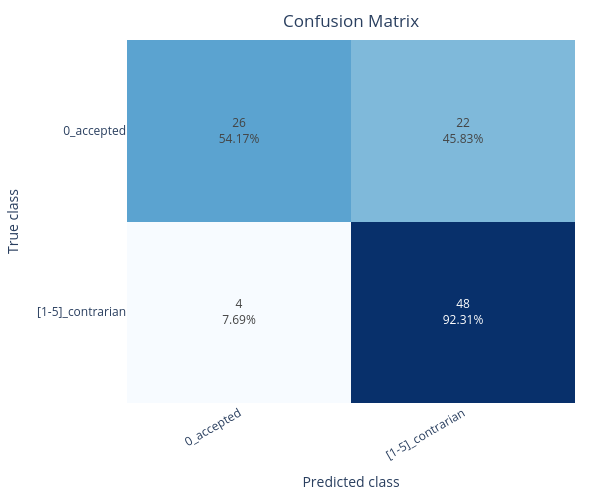

CARDS CLASSIFICATION REPORT

                                              precision    recall  f1-score   support

                                  0_accepted       0.87      0.54      0.67        48
                         1_its_not_happening       0.14      0.09      0.11        11
                                2_its_not_us       0.40      0.22      0.29         9
                               3_its_not_bad       0.47      0.78      0.58         9
                       4_solutions_wont_work       0.43      0.76      0.55        17
                     5_science_is_unreliable       0.33      0.67      0.44         6
Voici l'analyse de l'extrait :

3_its_not_ba       0.00      0.00      0.00         0

                                    accuracy                           0.53       100
                                   macro avg       0.38      0.44      0.38       100
                                weighted avg       0.60      0.53      0.53       100



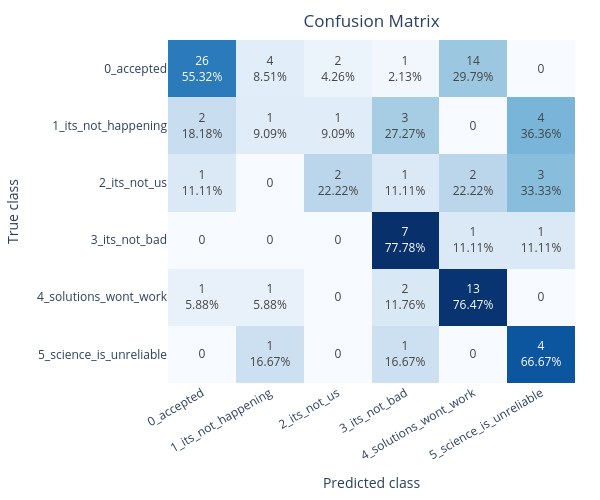

In [7]:
async def predict_cards_label(text: str) -> MediatreePrediction:
    system_prompt = """Tu es expert en désinformation sur les sujets environnementaux, expert en science climatique et sachant tout sur le GIEC. Je vais te donner un extrait d'une retranscription de 2 minutes d'un flux TV ou Radio. Ta tâche est d'identifier si l'extrait contient des affirmations trompeuses sur les thématiques environnementales (changement climatique, transition écologique, énergie, biodiversité, pollution, pesticides, ressources (eau, minéraux, ...). Ne fournis que le nom de la catégorie correcte, sans autre phrase d'introduction ou de conclusion.

<catégories prédéfinies>
- 0_accepted
- 1_its_not_happening
- 2_its_not_us
- 3_its_not_bad
- 4_solutions_wont_work
- 5_science_is_unreliable
</catégories prédéfinies>"""
    response = await acompletion(
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": text.strip()},
        ],
        model="anthropic.claude-3-haiku-20240307-v1:0",
        max_tokens=20,
        temperature=0,
    )
    cards_label_pred = response.choices[0].message.content
    return MediatreePrediction(
        cards_label_pred=cards_label_pred,
        prompt_tokens=response.usage.prompt_tokens,
        completion_tokens=response.usage.completion_tokens,
        total_tokens=response.usage.total_tokens,
        cost=completion_cost(response),
    )


await report_experiment_results(df, predict_cards_label)

## Add descriptions


### Description of categories based on the CARDS taxonomy


100%|██████████| 100/100 [00:13<00:00,  7.42it/s]


LLM USAGE

Median token usage:
- Prompt: 1457
- Completion: 7
- Total: 1464

Total cost: $0.037

BINARY CLASSIFICATION REPORT

              precision    recall  f1-score   support

       False       0.54      0.62      0.58        48
        True       0.59      0.50      0.54        52

    accuracy                           0.56       100
   macro avg       0.56      0.56      0.56       100
weighted avg       0.56      0.56      0.56       100



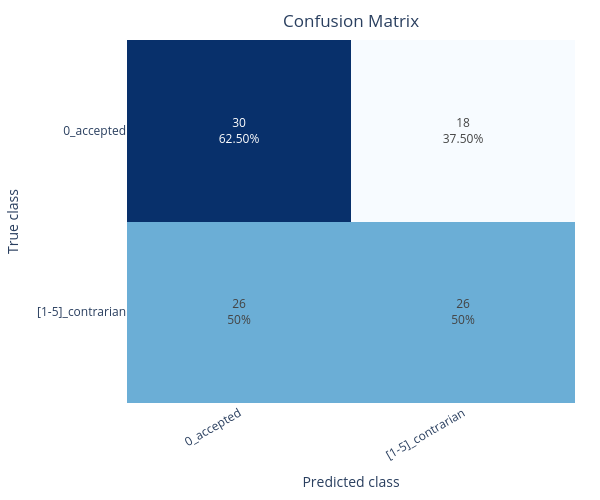

CARDS CLASSIFICATION REPORT

                         precision    recall  f1-score   support

             0_accepted       0.54      0.62      0.58        48
    1_its_not_happening       0.25      0.09      0.13        11
           2_its_not_us       0.25      0.11      0.15         9
          3_its_not_bad       0.33      0.11      0.17         9
  4_solutions_wont_work       0.42      0.47      0.44        17
5_science_is_unreliable       0.36      0.83      0.50         6

               accuracy                           0.46       100
              macro avg       0.36      0.37      0.33       100
           weighted avg       0.43      0.46      0.43       100



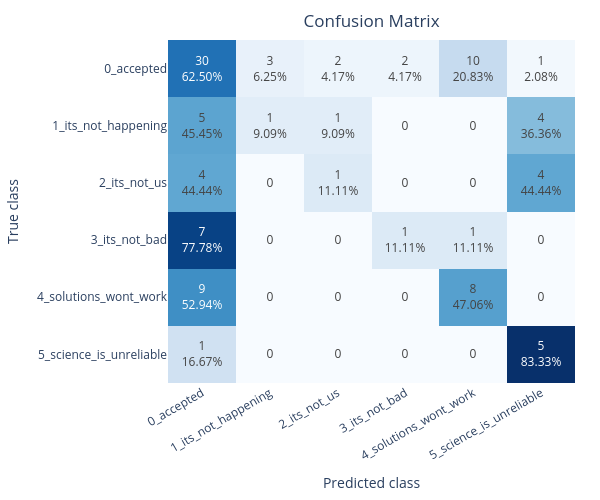

In [8]:
async def predict_cards_label(text: str) -> MediatreePrediction:
    system_prompt = """Tu es expert en désinformation sur les sujets environnementaux, expert en science climatique et sachant tout sur le GIEC. Je vais te donner un extrait d'une retranscription de 2 minutes d'un flux TV ou Radio. Ta tâche est d'identifier si l'extrait contient des affirmations trompeuses sur les thématiques environnementales (changement climatique, transition écologique, énergie, biodiversité, pollution, pesticides, ressources (eau, minéraux, ...).

<predefined_categories>
- 0_accepted: The text doesn't contain misinformation or is off topic.
- 1_its_not_happening
  - Ice isn't melting
    - Antarctica isn't melting
    - Greenland isn't melting
    - Arctic isn't melting
    - Glaciers aren't vanishing
  - Heading into ice age
  - Weather is cold
  - Hiatus in warming
  - Oceans are cooling
  - Sea level rise is exaggerated
  - Extreme aren't increasing
  - Changed the name
- 2_its_not_us
  - It's natural cycles
    - It's the sun
    - It's geological
    - It's the ocean
    - Past climate change
    - Tiny CO2 emissions
  - Non-Greenhouse Gas forcings
  - No evidence for Greenhouse Effect
    - CO2 is trace gas
    - Greenhouse Effect is saturated
    - CO2 lags climate
    - Water vapor
    - Tropospheric hot spot
    - CO2 high in past
  - CO2 not rising
  - Emissions not raising CO2 levels
- 3_its_not_bad
  - Sensitivity is low
  - No species impact
    - Species can adapt
    - Polar bears OK
    - Oceans are OK
  - Not a pollutant
    - CO2 is plant food
  - Only a few degrees
  - No link to conflict
  - No health impacts
- 4_solutions_wont_work
  - Policies are harmful
    - Policy increases costs
    - Policy weakens security
    - Policy harms environment
    - Risk future generations
    - Limits freedom
  - Policies are ineffective
    - Green jobs don't work
    - Markets more efficient
    - Policy impact is negligible
    - One country is negligible
    - Better to adapt
    - China's emissions
    - Techno fix
  - Too hard
    - Policy too difficult
    - Low public support
  - Clean energy won't work
    - Clean energy unreliable
    - Carbon Capture and Sequestration is unproven
  - We need energy
    - Fossil fuels are plentiful
    - Fossil fuels are cheap
    - Nuclear is good
- 5_science_is_unreliable
  - Science is unreliable
    - No consensus
    - Proxies are unreliable
    - Temp is unreliable
    - Models are unreliable
  - Movement is unreliable
    - Climate is religion
    - Media is alarmist
    - Politicians are biased
    - Environmentalists are alarmist
    - Scientists are biased
  - Climate is conspiracy
    - Policy is conspiracy
    - Science is conspiracy
</predefined_categories>

Ne fournis que le label de la catégorie correcte, sans autre phrase d'introduction ou de conclusion.
"""
    response = await acompletion(
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": text.strip()},
        ],
        model="anthropic.claude-3-haiku-20240307-v1:0",
        max_tokens=20,
        temperature=0,
    )
    cards_label_pred = response.choices[0].message.content
    return MediatreePrediction(
        cards_label_pred=cards_label_pred,
        prompt_tokens=response.usage.prompt_tokens,
        completion_tokens=response.usage.completion_tokens,
        total_tokens=response.usage.total_tokens,
        cost=completion_cost(response),
    )


await report_experiment_results(df, predict_cards_label)

### Generated descriptions from CARDS taxonomy


100%|██████████| 100/100 [00:13<00:00,  7.16it/s]



LLM USAGE

Median token usage:
- Prompt: 1854
- Completion: 7
- Total: 1861

Total cost: $0.047

BINARY CLASSIFICATION REPORT

              precision    recall  f1-score   support

       False       0.61      0.71      0.65        48
        True       0.68      0.58      0.62        52

    accuracy                           0.64       100
   macro avg       0.64      0.64      0.64       100
weighted avg       0.65      0.64      0.64       100



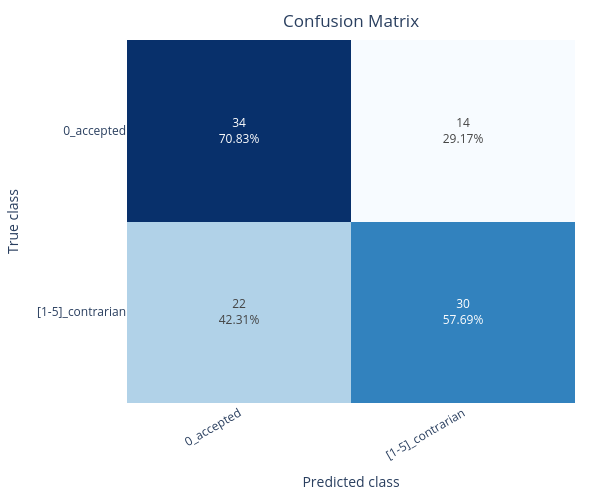

CARDS CLASSIFICATION REPORT

                         precision    recall  f1-score   support

             0_accepted       0.61      0.71      0.65        48
    1_its_not_happening       0.00      0.00      0.00        11
           1_its_not_us       0.00      0.00      0.00         0
           2_its_not_us       0.50      0.33      0.40         9
          3_its_not_bad       0.00      0.00      0.00         9
  4_solutions_wont_work       0.46      0.71      0.56        17
5_science_is_unreliable       0.45      0.83      0.59         6

               accuracy                           0.54       100
              macro avg       0.29      0.37      0.31       100
           weighted avg       0.44      0.54      0.48       100



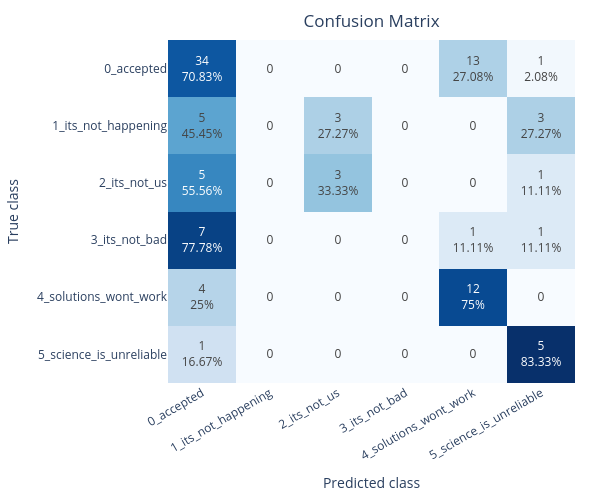

In [9]:
async def predict_cards_label(text: str) -> MediatreePrediction:
    system_prompt = """Tu es expert en désinformation sur les sujets environnementaux, expert en science climatique et sachant tout sur le GIEC. Je vais te donner un extrait d'une retranscription de 2 minutes d'un flux TV ou Radio. Ta tâche est d'identifier si l'extrait contient des affirmations trompeuses sur les thématiques environnementales (changement climatique, transition écologique, énergie, biodiversité, pollution, pesticides, ressources (eau, minéraux, ...).

<catégories prédéfinies>
- 0_accepted: Lorsque l'ensemble de l'extrait est neutre ou reflète le consensus scientifique sur les questions climatiques, sans contenir de désinformation. Cette catégorie est aussi adaptée si l'extrait n'aborde pas le sujet du climat.
- 1_its_not_happening: Le réchauffement climatique n'a pas lieu. Cette catégorie soutient que le changement climatique est inexistant ou largement exagéré. Elle suggère que des facteurs naturels — tels que le froid, la préservation de la glace et le refroidissement des océans — prouvent que le réchauffement n'est pas en cours. De plus, elle implique que les prévisions de changements climatiques sévères, y compris la montée du niveau de la mer et les phénomènes météorologiques extrêmes, sont exagérées ou inventées. Certaines affirmations soutiennent que la terminologie climatique a été manipulée (par exemple, en passant de "réchauffement climatique" à "changement climatique") pour alarmer le public sans raison.
- 2_its_not_us: Les humains ne sont pas à l'origine du réchauffement climatique. Cette catégorie avance que les activités humaines, en particulier les émissions de gaz à effet de serre, ne sont pas responsables du réchauffement observé. Elle soutient que les cycles naturels, l'activité solaire ou d'autres facteurs non humains sont à l'origine des changements climatiques. Les affirmations de cette catégorie minimisent souvent le rôle du CO2, ou soulignent que les changements climatiques passés se sont produits sans intervention humaine, suggérant que le réchauffement actuel est également naturel.
- 3_its_not_bad: Les impacts climatiques ne sont pas mauvais. Cette catégorie reconnaît qu'un certain réchauffement pourrait se produire, mais affirme qu'il pose peu de risques. Les arguments de cette catégorie suggèrent que la sensibilité du climat au CO2 est faible, ce qui limiterait le réchauffement. Les partisans prétendent que l'environnement, les espèces et la santé humaine seront largement épargnés, car les plantes bénéficient de l'augmentation du CO2, et que de nombreuses espèces, comme les ours polaires, peuvent s'adapter. Dans l'ensemble, elle suggère que les impacts climatiques seront mineurs et gérables.
- 4_solutions_wont_work: Les solutions climatiques ne fonctionneront pas. Cette catégorie s'oppose aux politiques climatiques proposées, en affirmant qu'elles seront nuisibles économiquement ou socialement, inefficaces ou irréalistes. Elle soutient que les politiques de réduction des émissions augmenteront les coûts, affaibliront la sécurité nationale et restreindront les libertés individuelles sans bénéfices climatiques significatifs. D'autres affirmations proposent que les solutions "vertes" sont peu fiables, que l'énergie propre est non éprouvée, ou que les combustibles fossiles sont abondants et essentiels pour l'avenir. Essentiellement, elle soutient que les politiques climatiques sont trop coûteuses, difficiles ou inefficaces pour être poursuivies.
- 5_science_is_unreliable: Les mouvements pour le climat et la science du climat ne sont pas fiables. Cette catégorie attaque la crédibilité de la science climatique et du mouvement pour le climat, affirmant qu'ils sont non fiables, biaisés ou idéologiquement orientés. Elle remet en question le consensus scientifique sur le changement climatique, suggérant que les données, modèles et méthodes sont défectueux. De plus, elle présente le mouvement climatique comme alarmiste, biaisé ou faisant partie d'une conspiration plus large, motivée par des intentions politiques ou religieuses plutôt qu'une véritable préoccupation. Ce cadre cherche à miner la confiance dans la science climatique et dans ceux qui plaident pour l'action.
</catégories prédéfinies>

Ne fournis que le label de la catégorie correcte, sans autre phrase d'introduction ou de conclusion.
"""
    response = await acompletion(
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": text.strip()},
        ],
        model="anthropic.claude-3-haiku-20240307-v1:0",
        max_tokens=20,
        temperature=0,
    )
    cards_label_pred = response.choices[0].message.content
    return MediatreePrediction(
        cards_label_pred=cards_label_pred,
        prompt_tokens=response.usage.prompt_tokens,
        completion_tokens=response.usage.completion_tokens,
        total_tokens=response.usage.total_tokens,
        cost=completion_cost(response),
    )


await report_experiment_results(df, predict_cards_label)

## Add examples + Prefilling the response to avoid blah blah


100%|██████████| 100/100 [00:13<00:00,  7.15it/s]



LLM USAGE

Median token usage:
- Prompt: 2520
- Completion: 8
- Total: 2528

Total cost: $0.064

BINARY CLASSIFICATION REPORT

              precision    recall  f1-score   support

       False       0.67      0.88      0.76        48
        True       0.84      0.60      0.70        52

    accuracy                           0.73       100
   macro avg       0.75      0.74      0.73       100
weighted avg       0.76      0.73      0.73       100



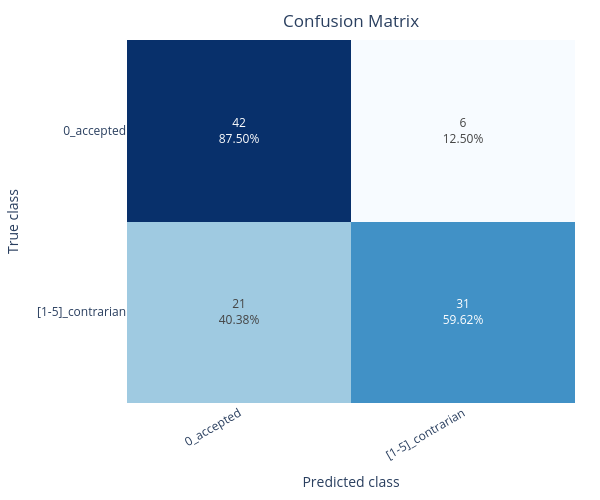

CARDS CLASSIFICATION REPORT

                         precision    recall  f1-score   support

             0_accepted       0.67      0.88      0.76        48
    1_its_not_happening       0.00      0.00      0.00        11
           2_its_not_us       0.64      0.78      0.70         9
          3_its_not_bad       0.50      0.11      0.18         9
  4_solutions_wont_work       0.67      0.59      0.62        17
5_science_is_unreliable       0.56      0.83      0.67         6

               accuracy                           0.65       100
              macro avg       0.50      0.53      0.49       100
           weighted avg       0.57      0.65      0.59       100



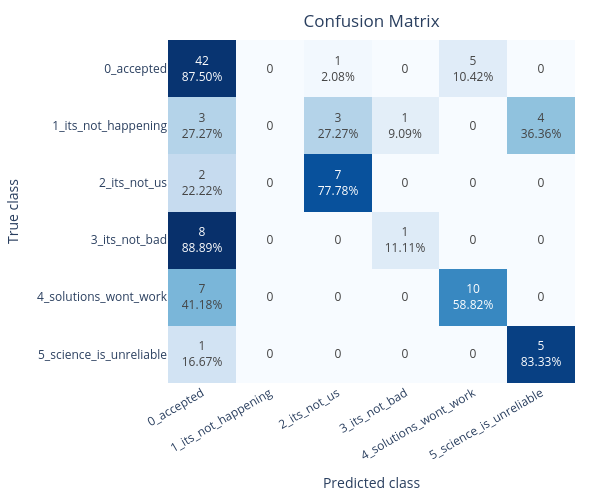

In [10]:
async def predict_cards_label(text: str) -> MediatreePrediction:
    system_prompt = """Tu es expert en désinformation sur les sujets environnementaux, expert en science climatique et sachant tout sur le GIEC. Je vais te donner un extrait d'une retranscription de 2 minutes d'un flux TV ou Radio. Ta tâche est d'identifier si l'extrait contient des affirmations trompeuses sur les thématiques environnementales (changement climatique, transition écologique, énergie, biodiversité, pollution, pesticides, ressources (eau, minéraux, ...). Ne fournis que le label de la catégorie correcte, sans autre phrase d'introduction ou de conclusion.

<catégories prédéfinies>
- 0_accepted: Lorsque l'ensemble de l'extrait est neutre ou reflète le consensus scientifique sur les questions climatiques, sans contenir de désinformation. Cette catégorie est aussi adaptée si l'extrait n'aborde pas le sujet du climat.
- 1_its_not_happening: Le réchauffement climatique n'a pas lieu. Cette catégorie soutient que le changement climatique est inexistant ou largement exagéré. Elle suggère que des facteurs naturels (tels que le froid, la préservation de la glace et le refroidissement des océans) prouvent que le réchauffement n'est pas en cours. De plus, elle implique que les prévisions de changements climatiques sévères, y compris la montée du niveau de la mer et les phénomènes météorologiques extrêmes, sont exagérées ou inventées. Certaines affirmations soutiennent que la terminologie climatique a été manipulée (par exemple, en passant de "réchauffement climatique" à "changement climatique") pour alarmer le public sans raison.
- 2_its_not_us: Les humains ne sont pas à l'origine du réchauffement climatique. Cette catégorie avance que les activités humaines, en particulier les émissions de gaz à effet de serre, ne sont pas responsables du réchauffement observé. Elle soutient que les cycles naturels, l'activité solaire ou d'autres facteurs non humains sont à l'origine des changements climatiques. Les affirmations de cette catégorie minimisent souvent le rôle du CO2, ou soulignent que les changements climatiques passés se sont produits sans intervention humaine, suggérant que le réchauffement actuel est également naturel.
- 3_its_not_bad: Les impacts climatiques ne sont pas mauvais. Cette catégorie reconnaît qu'un certain réchauffement pourrait se produire, mais affirme qu'il pose peu de risques. Les arguments de cette catégorie suggèrent que la sensibilité du climat au CO2 est faible, ce qui limiterait le réchauffement. Les partisans prétendent que l'environnement, les espèces et la santé humaine seront largement épargnés, car les plantes bénéficient de l'augmentation du CO2, et que de nombreuses espèces, comme les ours polaires, peuvent s'adapter. Dans l'ensemble, elle suggère que les impacts climatiques seront mineurs et gérables.
- 4_solutions_wont_work: Les solutions climatiques ne fonctionneront pas. Cette catégorie s'oppose aux politiques climatiques proposées, en affirmant qu'elles seront nuisibles économiquement ou socialement, inefficaces ou irréalistes. Elle soutient que les politiques de réduction des émissions augmenteront les coûts, affaibliront la sécurité nationale et restreindront les libertés individuelles sans bénéfices climatiques significatifs. D'autres affirmations proposent que les solutions "vertes" sont peu fiables, que l'énergie propre est non éprouvée, ou que les combustibles fossiles sont abondants et essentiels pour l'avenir. Essentiellement, elle soutient que les politiques climatiques sont trop coûteuses, difficiles ou inefficaces pour être poursuivies.
- 5_science_is_unreliable: Les mouvements pour le climat et la science du climat ne sont pas fiables. Cette catégorie attaque la crédibilité de la science climatique et du mouvement pour le climat, affirmant qu'ils sont non fiables, biaisés ou idéologiquement orientés. Elle remet en question le consensus scientifique sur le changement climatique, suggérant que les données, modèles et méthodes sont défectueux. De plus, elle présente le mouvement climatique comme alarmiste, biaisé ou faisant partie d'une conspiration plus large, motivée par des intentions politiques ou religieuses plutôt qu'une véritable préoccupation. Ce cadre cherche à miner la confiance dans la science climatique et dans ceux qui plaident pour l'action.
</catégories prédéfinies>

<exemples>

<exemple_0>
<extrait>
[...] les scientifiques observent une hausse des températures mondiales, entraînant des changements climatiques visibles ils soulignent la nécessité d'agir pour en limiter les impacts [...]
</extrait>
<catégorie>0_accepted</catégorie>
</exemple_0>

<exemple_1>
<extrait>
[...] la fréquence des discussions sur la crise climatique semble augmenter mais certains experts proposent que les avertissements sur le climat pourraient être exagérés faisant souvent valoir que les fluctuations climatiques sont tout à fait naturelles et que les vérités scientifiques sont parfois altérées pour servir des intérêts politiques [...]
</extrait>
<catégorie>1_its_not_happening</catégorie>
</exemple_1>

<exemple_2>
<extrait>
[...] il est contesté que la contribution humaine aux niveaux de CO2 soit réellement significative certains experts soutiennent que les océans jouent un rôle bien plus important dans l'émission de ce gaz [...]
</extrait>
<catégorie>2_its_not_us</catégorie>
</exemple_2>

<exemple_3>
<extrait>
[...] il est important de noter que beaucoup de régions touchées par des événements climatiques extrêmes retrouvent leur équilibre naturel et peuvent même bénéficier de ces changements car plusieurs études montrent que certaines espèces et écosystèmes s'adaptent efficacement aux variations climatiques [...]
</extrait>
<catégorie>3_its_not_bad</catégorie>
</exemple_3>

<exemple_4>
<extrait>
[...] de nombreux experts remettent en question l'efficacité des initiatives visant à réduire la pollution, arguant qu'elles ne font qu'ajouter des coûts économiques sans réel impact positif sur l'environnement [...]
</extrait>
<catégorie>4_solutions_wont_work</catégorie>
</exemple_4>

<exemple_5>
<extrait>
[...] En réfléchissant à la situation on peut voir un parallèle avec le débat climatique de nombreux sceptiques pensent que le discours autour du climat est devenu une sorte de dogme où la critique est difficilement tolérée [...]
</extrait>
<catégorie>5_science_is_unreliable</catégorie>
</exemple_5>

</exemples>
"""
    response = await acompletion(
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": f"<extrait>\n{text.strip()}\n</extrait>"},
            {"role": "assistant", "content": "<catégorie>", "prefix": True},
        ],
        model="anthropic.claude-3-haiku-20240307-v1:0",
        max_tokens=20,
        temperature=0,
        stop=["</catégorie>"],
    )
    cards_label_pred = response.choices[0].message.content.strip()
    return MediatreePrediction(
        cards_label_pred=cards_label_pred,
        prompt_tokens=response.usage.prompt_tokens,
        completion_tokens=response.usage.completion_tokens,
        total_tokens=response.usage.total_tokens,
        cost=completion_cost(response),
    )


await report_experiment_results(df, predict_cards_label)

## Trying to find the hidden contrarian claim 🕵️‍♂️


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


LLM USAGE

Median token usage:
- Prompt: 2628
- Completion: 64
- Total: 2697

Total cost: $0.073

BINARY CLASSIFICATION REPORT

              precision    recall  f1-score   support

       False       0.94      0.98      0.96        48
        True       0.98      0.94      0.96        52

    accuracy                           0.96       100
   macro avg       0.96      0.96      0.96       100
weighted avg       0.96      0.96      0.96       100



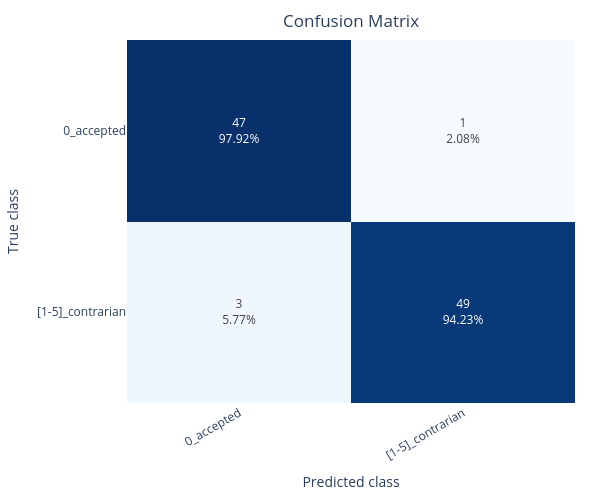

CARDS CLASSIFICATION REPORT

                         precision    recall  f1-score   support

             0_accepted       0.94      0.98      0.96        48
    1_its_not_happening       0.80      0.36      0.50        11
           2_its_not_us       0.70      0.78      0.74         9
          3_its_not_bad       0.67      0.89      0.76         9
  4_solutions_wont_work       0.92      0.65      0.76        17
5_science_is_unreliable       0.55      1.00      0.71         6

               accuracy                           0.83       100
              macro avg       0.76      0.78      0.74       100
           weighted avg       0.85      0.83      0.82       100



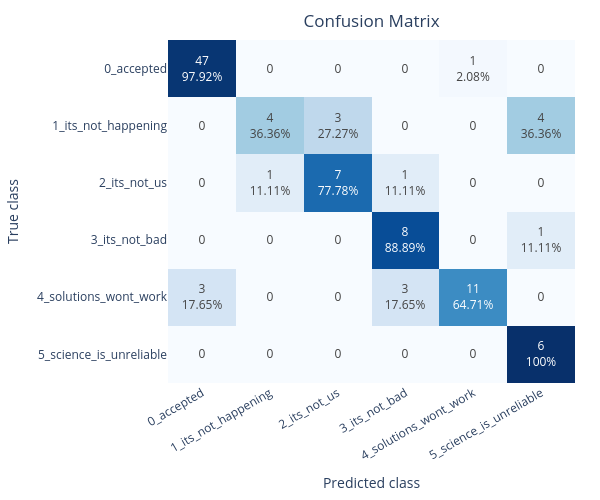

CLAIMS EXTRATION EVALUATION

BLEU: 0.74
ROUGE: 0.93


In [11]:
async def predict_cards_label(text: str) -> MediatreePrediction:
    system_prompt = """Tu es expert en désinformation sur les sujets environnementaux, expert en science climatique et sachant tout sur le GIEC. Je vais te donner un extrait d'une retranscription de 2 minutes d'un flux TV ou Radio. Parmis certains extraits, nous avons inséré un passage climatosceptique qui doit être factchecker. Ta tâche est de trouver ce passage climatosceptique (si il existe). Isole le passage à factchecker, puis fournis le label de la catégorie associé à ce passage. Ne t'intéresse qu'aux passages qui sont clairement climatosceptiques et ignore les thématiques sociales et/ou économiques. 

<catégories prédéfinies>
- 0_accepted: Lorsque l'ensemble de l'extrait est neutre ou reflète le consensus scientifique sur les questions climatiques, sans contenir de désinformation. Cette catégorie est aussi adaptée si l'extrait n'aborde pas le sujet du climat.
- 1_its_not_happening: Le réchauffement climatique n'a pas lieu. Cette catégorie soutient que le changement climatique est inexistant ou largement exagéré. Elle suggère que des facteurs naturels (tels que le froid, la préservation de la glace et le refroidissement des océans) prouvent que le réchauffement n'est pas en cours. De plus, elle implique que les prévisions de changements climatiques sévères, y compris la montée du niveau de la mer et les phénomènes météorologiques extrêmes, sont exagérées ou inventées. Certaines affirmations soutiennent que la terminologie climatique a été manipulée (par exemple, en passant de "réchauffement climatique" à "changement climatique") pour alarmer le public sans raison.
- 2_its_not_us: Les humains ne sont pas à l'origine du réchauffement climatique. Cette catégorie avance que les activités humaines, en particulier les émissions de gaz à effet de serre, ne sont pas responsables du réchauffement observé. Elle soutient que les cycles naturels, l'activité solaire ou d'autres facteurs non humains sont à l'origine des changements climatiques. Les affirmations de cette catégorie minimisent souvent le rôle du CO2, ou soulignent que les changements climatiques passés se sont produits sans intervention humaine, suggérant que le réchauffement actuel est également naturel.
- 3_its_not_bad: Les impacts climatiques ne sont pas mauvais. Cette catégorie reconnaît qu'un certain réchauffement pourrait se produire, mais affirme qu'il pose peu de risques. Les arguments de cette catégorie suggèrent que la sensibilité du climat au CO2 est faible, ce qui limiterait le réchauffement. Les partisans prétendent que l'environnement, les espèces et la santé humaine seront largement épargnés, car les plantes bénéficient de l'augmentation du CO2, et que de nombreuses espèces, comme les ours polaires, peuvent s'adapter. Dans l'ensemble, elle suggère que les impacts climatiques seront mineurs et gérables.
- 4_solutions_wont_work: Les solutions climatiques ne fonctionneront pas. Cette catégorie s'oppose aux politiques climatiques proposées, en affirmant qu'elles seront nuisibles économiquement ou socialement, inefficaces ou irréalistes. Elle soutient que les politiques de réduction des émissions augmenteront les coûts, affaibliront la sécurité nationale et restreindront les libertés individuelles sans bénéfices climatiques significatifs. D'autres affirmations proposent que les solutions "vertes" sont peu fiables, que l'énergie propre est non éprouvée, ou que les combustibles fossiles sont abondants et essentiels pour l'avenir. Essentiellement, elle soutient que les politiques climatiques sont trop coûteuses, difficiles ou inefficaces pour être poursuivies.
- 5_science_is_unreliable: Les mouvements pour le climat et la science du climat ne sont pas fiables. Cette catégorie attaque la crédibilité de la science climatique et du mouvement pour le climat, affirmant qu'ils sont non fiables, biaisés ou idéologiquement orientés. Elle remet en question le consensus scientifique sur le changement climatique, suggérant que les données, modèles et méthodes sont défectueux. De plus, elle présente le mouvement climatique comme alarmiste, biaisé ou faisant partie d'une conspiration plus large, motivée par des intentions politiques ou religieuses plutôt qu'une véritable préoccupation. Ce cadre cherche à miner la confiance dans la science climatique et dans ceux qui plaident pour l'action.
</catégories prédéfinies>

<exemples>

<exemple_0>
<extrait>
les scientifiques observent une hausse des températures mondiales, entraînant des changements climatiques visibles ils soulignent la nécessité d'agir pour en limiter les impacts [...]
</extrait>
<passage climatosceptique>
AUCUN
</passage climatosceptique>
<catégorie>0_accepted</catégorie>
</exemple_0>

<exemple_1>
<extrait>
[...]
</extrait>
<passage climatosceptique>
la fréquence des discussions sur la crise climatique semble augmenter mais certains experts proposent que les avertissements sur le climat pourraient être exagérés faisant souvent valoir que les fluctuations climatiques sont tout à fait naturelles et que les vérités scientifiques sont parfois altérées pour servir des intérêts politiques
</passage climatosceptique>
<catégorie>1_its_not_happening</catégorie>
</exemple_1>

<exemple_2>
<extrait>
[...]
</extrait>
<passage climatosceptique>
il est contesté que la contribution humaine aux niveaux de CO2 soit réellement significative certains experts soutiennent que les océans jouent un rôle bien plus important dans l'émission de ce gaz
</passage climatosceptique>
<catégorie>2_its_not_us</catégorie>
</exemple_2>

<exemple_3>
<extrait>
[...]
</extrait>
<passage climatosceptique>
il est important de noter que beaucoup de régions touchées par des événements climatiques extrêmes retrouvent leur équilibre naturel et peuvent même bénéficier de ces changements car plusieurs études montrent que certaines espèces et écosystèmes s'adaptent efficacement aux variations climatiques
</passage climatosceptique>
<catégorie>3_its_not_bad</catégorie>
</exemple_3>

<exemple_4>
<extrait>
[...]
</extrait>
<passage climatosceptique>
de nombreux experts remettent en question l'efficacité des initiatives visant à réduire la pollution, arguant qu'elles ne font qu'ajouter des coûts économiques sans réel impact positif sur l'environnement
</passage climatosceptique>
<catégorie>4_solutions_wont_work</catégorie>
</exemple_4>

<exemple_5>
<extrait>
[...]
</extrait>
<passage climatosceptique>
En réfléchissant à la situation on peut voir un parallèle avec le débat climatique de nombreux sceptiques pensent que le discours autour du climat est devenu une sorte de dogme où la critique est difficilement tolérée
</passage climatosceptique>
<catégorie>5_science_is_unreliable</catégorie>
</exemple_5>

</exemples>
"""
    response = await acompletion(
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": f"<extrait>\n{text.strip()}\n</extrait>"},
            {
                "role": "assistant",
                "content": "<passage climatosceptique>",
                "prefix": True,
            },
        ],
        model="anthropic.claude-3-haiku-20240307-v1:0",
        max_tokens=1000,
        temperature=0,
        stop=["</catégorie>"],
    )

    # Parse the response
    response_content: str = response.choices[0].message.content
    claim = response_content.split("</passage climatosceptique>")[0].strip()
    cards_label_pred = response_content.split("<catégorie>")[1].strip()
    return MediatreePrediction(
        cards_label_pred=cards_label_pred,
        prompt_tokens=response.usage.prompt_tokens,
        completion_tokens=response.usage.completion_tokens,
        total_tokens=response.usage.total_tokens,
        cost=completion_cost(response),
        claim_pred=claim if cards_label_pred != "0_accepted" else None,
    )


await report_experiment_results(df, predict_cards_label)

## Claude Haiku vs OpenAI gpt-4o-mini


100%|██████████| 100/100 [00:08<00:00, 12.14it/s]


LLM USAGE

Median token usage:
- Prompt: 2025
- Completion: 60
- Total: 2082

Total cost: $0.023

BINARY CLASSIFICATION REPORT

              precision    recall  f1-score   support

       False       1.00      0.90      0.95        48
        True       0.91      1.00      0.95        52

    accuracy                           0.95       100
   macro avg       0.96      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100



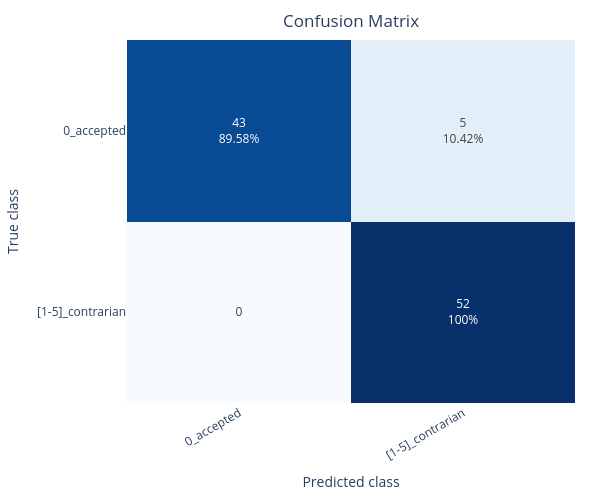

CARDS CLASSIFICATION REPORT

                         precision    recall  f1-score   support

             0_accepted       1.00      0.90      0.95        48
    1_its_not_happening       0.62      0.45      0.53        11
           2_its_not_us       0.67      0.89      0.76         9
          3_its_not_bad       0.73      0.89      0.80         9
  4_solutions_wont_work       0.88      0.88      0.88        17
5_science_is_unreliable       0.67      1.00      0.80         6

               accuracy                           0.85       100
              macro avg       0.76      0.84      0.79       100
           weighted avg       0.86      0.85      0.85       100



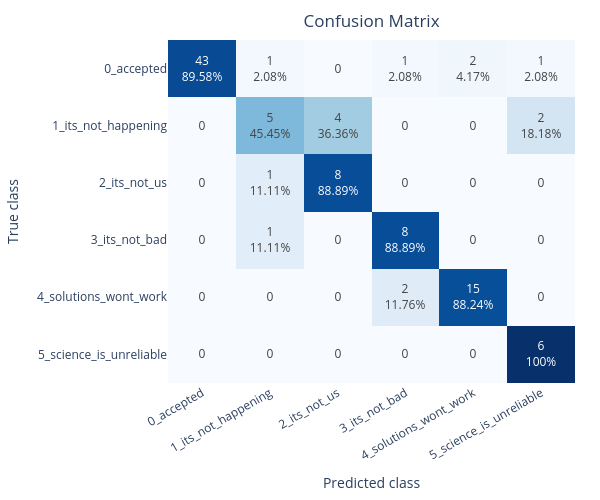

CLAIMS EXTRATION EVALUATION

BLEU: 0.74
ROUGE: 0.95


In [12]:
async def openai_predict_cards_label(text: str) -> MediatreePrediction:
    system_prompt = """Tu es expert en désinformation sur les sujets environnementaux, expert en science climatique et sachant tout sur le GIEC. Je vais te donner un extrait d'une retranscription de 2 minutes d'un flux TV ou Radio. Parmis certains extraits, nous avons inséré un passage climatosceptique qui doit être factchecker. Ta tâche est de trouver ce passage climatosceptique (si il existe). Isole le passage à factchecker, puis fournis le label de la catégorie associé à ce passage. Ne t'intéresse qu'aux passages qui sont clairement climatosceptiques et ignore les thématiques sociales et/ou économiques. 

<catégories prédéfinies>
- 0_accepted: Lorsque l'ensemble de l'extrait est neutre ou reflète le consensus scientifique sur les questions climatiques, sans contenir de désinformation. Cette catégorie est aussi adaptée si l'extrait n'aborde pas le sujet du climat.
- 1_its_not_happening: Le réchauffement climatique n'a pas lieu. Cette catégorie soutient que le changement climatique est inexistant ou largement exagéré. Elle suggère que des facteurs naturels (tels que le froid, la préservation de la glace et le refroidissement des océans) prouvent que le réchauffement n'est pas en cours. De plus, elle implique que les prévisions de changements climatiques sévères, y compris la montée du niveau de la mer et les phénomènes météorologiques extrêmes, sont exagérées ou inventées. Certaines affirmations soutiennent que la terminologie climatique a été manipulée (par exemple, en passant de "réchauffement climatique" à "changement climatique") pour alarmer le public sans raison.
- 2_its_not_us: Les humains ne sont pas à l'origine du réchauffement climatique. Cette catégorie avance que les activités humaines, en particulier les émissions de gaz à effet de serre, ne sont pas responsables du réchauffement observé. Elle soutient que les cycles naturels, l'activité solaire ou d'autres facteurs non humains sont à l'origine des changements climatiques. Les affirmations de cette catégorie minimisent souvent le rôle du CO2, ou soulignent que les changements climatiques passés se sont produits sans intervention humaine, suggérant que le réchauffement actuel est également naturel.
- 3_its_not_bad: Les impacts climatiques ne sont pas mauvais. Cette catégorie reconnaît qu'un certain réchauffement pourrait se produire, mais affirme qu'il pose peu de risques. Les arguments de cette catégorie suggèrent que la sensibilité du climat au CO2 est faible, ce qui limiterait le réchauffement. Les partisans prétendent que l'environnement, les espèces et la santé humaine seront largement épargnés, car les plantes bénéficient de l'augmentation du CO2, et que de nombreuses espèces, comme les ours polaires, peuvent s'adapter. Dans l'ensemble, elle suggère que les impacts climatiques seront mineurs et gérables.
- 4_solutions_wont_work: Les solutions climatiques ne fonctionneront pas. Cette catégorie s'oppose aux politiques climatiques proposées, en affirmant qu'elles seront nuisibles économiquement ou socialement, inefficaces ou irréalistes. Elle soutient que les politiques de réduction des émissions augmenteront les coûts, affaibliront la sécurité nationale et restreindront les libertés individuelles sans bénéfices climatiques significatifs. D'autres affirmations proposent que les solutions "vertes" sont peu fiables, que l'énergie propre est non éprouvée, ou que les combustibles fossiles sont abondants et essentiels pour l'avenir. Essentiellement, elle soutient que les politiques climatiques sont trop coûteuses, difficiles ou inefficaces pour être poursuivies.
- 5_science_is_unreliable: Les mouvements pour le climat et la science du climat ne sont pas fiables. Cette catégorie attaque la crédibilité de la science climatique et du mouvement pour le climat, affirmant qu'ils sont non fiables, biaisés ou idéologiquement orientés. Elle remet en question le consensus scientifique sur le changement climatique, suggérant que les données, modèles et méthodes sont défectueux. De plus, elle présente le mouvement climatique comme alarmiste, biaisé ou faisant partie d'une conspiration plus large, motivée par des intentions politiques ou religieuses plutôt qu'une véritable préoccupation. Ce cadre cherche à miner la confiance dans la science climatique et dans ceux qui plaident pour l'action.
</catégories prédéfinies>

<exemples>

<exemple_0>
<extrait>
les scientifiques observent une hausse des températures mondiales, entraînant des changements climatiques visibles ils soulignent la nécessité d'agir pour en limiter les impacts [...]
</extrait>
<passage climatosceptique>
AUCUN
</passage climatosceptique>
<catégorie>0_accepted</catégorie>
</exemple_0>

<exemple_1>
<extrait>
[...]
</extrait>
<passage climatosceptique>
la fréquence des discussions sur la crise climatique semble augmenter mais certains experts proposent que les avertissements sur le climat pourraient être exagérés faisant souvent valoir que les fluctuations climatiques sont tout à fait naturelles et que les vérités scientifiques sont parfois altérées pour servir des intérêts politiques
</passage climatosceptique>
<catégorie>1_its_not_happening</catégorie>
</exemple_1>

<exemple_2>
<extrait>
[...]
</extrait>
<passage climatosceptique>
il est contesté que la contribution humaine aux niveaux de CO2 soit réellement significative certains experts soutiennent que les océans jouent un rôle bien plus important dans l'émission de ce gaz
</passage climatosceptique>
<catégorie>2_its_not_us</catégorie>
</exemple_2>

<exemple_3>
<extrait>
[...]
</extrait>
<passage climatosceptique>
il est important de noter que beaucoup de régions touchées par des événements climatiques extrêmes retrouvent leur équilibre naturel et peuvent même bénéficier de ces changements car plusieurs études montrent que certaines espèces et écosystèmes s'adaptent efficacement aux variations climatiques
</passage climatosceptique>
<catégorie>3_its_not_bad</catégorie>
</exemple_3>

<exemple_4>
<extrait>
[...]
</extrait>
<passage climatosceptique>
de nombreux experts remettent en question l'efficacité des initiatives visant à réduire la pollution, arguant qu'elles ne font qu'ajouter des coûts économiques sans réel impact positif sur l'environnement
</passage climatosceptique>
<catégorie>4_solutions_wont_work</catégorie>
</exemple_4>

<exemple_5>
<extrait>
[...]
</extrait>
<passage climatosceptique>
En réfléchissant à la situation on peut voir un parallèle avec le débat climatique de nombreux sceptiques pensent que le discours autour du climat est devenu une sorte de dogme où la critique est difficilement tolérée
</passage climatosceptique>
<catégorie>5_science_is_unreliable</catégorie>
</exemple_5>

</exemples>
"""
    response = await acompletion(
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": f"<extrait>\n{text.strip()}\n</extrait>"},
        ],
        model="gpt-4o-mini",
        max_tokens=1000,
        temperature=0,
        stop=["</catégorie>"],
    )

    # Parse the response
    response_content: str = response.choices[0].message.content
    claim = (
        response_content.split("<passage climatosceptique>")[1]
        .split("</passage climatosceptique>")[0]
        .strip()
    )
    cards_label_pred = response_content.split("<catégorie>")[1].strip()
    return MediatreePrediction(
        cards_label_pred=cards_label_pred,
        prompt_tokens=response.usage.prompt_tokens,
        completion_tokens=response.usage.completion_tokens,
        total_tokens=response.usage.total_tokens,
        cost=completion_cost(response),
        claim_pred=claim if cards_label_pred != "0_accepted" else None,
    )


await report_experiment_results(df, openai_predict_cards_label)

## Test on the full benchmark sample


100%|██████████| 100/100 [00:27<00:00,  3.59it/s]


LLM USAGE

Median token usage:
- Prompt: 1785
- Completion: 72
- Total: 1862

Total cost: $0.053

BINARY CLASSIFICATION REPORT

              precision    recall  f1-score   support

       False       0.98      0.96      0.97        48
        True       0.96      0.98      0.97        52

    accuracy                           0.97       100
   macro avg       0.97      0.97      0.97       100
weighted avg       0.97      0.97      0.97       100



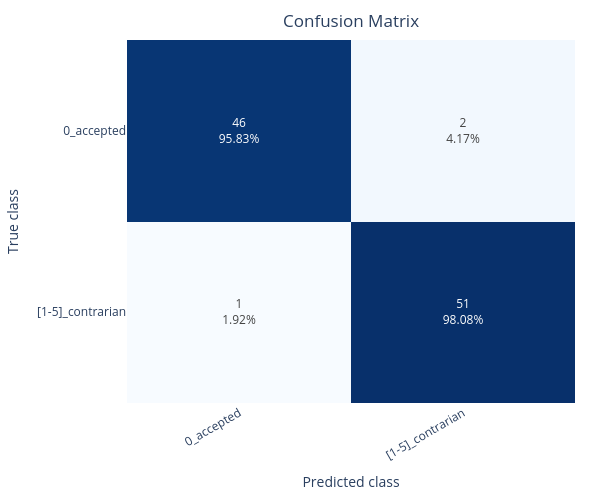

CARDS CLASSIFICATION REPORT

                         precision    recall  f1-score   support

             0_accepted       0.98      0.96      0.97        48
    1_its_not_happening       0.80      0.36      0.50        11
           2_its_not_us       0.70      0.78      0.74         9
          3_its_not_bad       0.80      0.89      0.84         9
  4_solutions_wont_work       0.88      0.88      0.88        17
5_science_is_unreliable       0.55      1.00      0.71         6

               accuracy                           0.86       100
              macro avg       0.78      0.81      0.77       100
           weighted avg       0.88      0.86      0.85       100



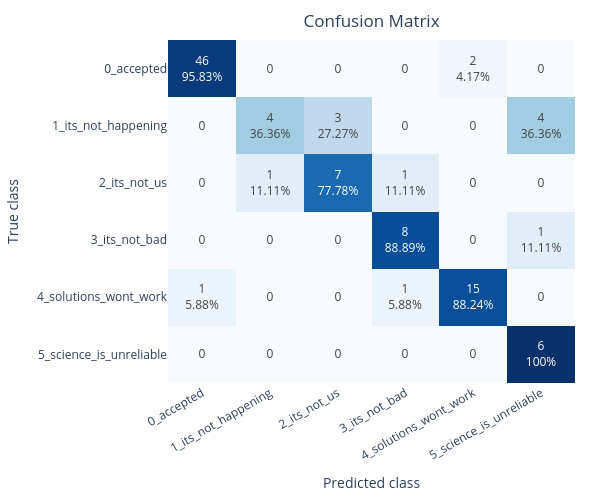

CLAIMS EXTRATION EVALUATION

BLEU: 0.77
ROUGE: 0.96


In [14]:
# Actually I realized the descriptions of categories don't help with performance
# It's a bit surprising... maybe the few-shot claim examples are very similar to the test claims?
async def predict_cards_label(text: str) -> MediatreePrediction:
    system_prompt = """Tu es expert en désinformation sur les sujets environnementaux, expert en science climatique et sachant tout sur le GIEC. Je vais te donner un extrait d'une retranscription de 2 minutes d'un flux TV ou Radio. Parmis certains extraits, nous avons inséré un passage climatosceptique qui doit être factchecker. Ta tâche est de trouver ce passage climatosceptique (si il existe). Isole le passage à factchecker, puis fournis le label de la catégorie associé à ce passage. Ne t'intéresse qu'aux passages qui sont clairement climatosceptiques et ignore les thématiques sociales et/ou économiques. 

<catégories prédéfinies>
- 0_accepted: Lorsque l'ensemble de l'extrait est neutre ou reflète le consensus scientifique sur les questions climatiques, sans contenir de désinformation. Cette catégorie est aussi adaptée si l'extrait n'aborde pas le sujet du climat.
- 1_its_not_happening: Le réchauffement climatique n'a pas lieu.
- 2_its_not_us: Les humains ne sont pas à l'origine du réchauffement climatique.
- 3_its_not_bad: Les impacts climatiques ne sont pas mauvais.
- 4_solutions_wont_work: Les solutions climatiques ne fonctionneront pas.
- 5_science_is_unreliable: Les mouvements pour le climat et la science du climat ne sont pas fiables.
</catégories prédéfinies>

<exemples>

<exemple_0>
<extrait>
les scientifiques observent une hausse des températures mondiales, entraînant des changements climatiques visibles ils soulignent la nécessité d'agir pour en limiter les impacts [...]
</extrait>
<passage climatosceptique>
AUCUN
</passage climatosceptique>
<catégorie>0_accepted</catégorie>
</exemple_0>

<exemple_1>
<extrait>
[...]
</extrait>
<passage climatosceptique>
la fréquence des discussions sur la crise climatique semble augmenter mais certains experts proposent que les avertissements sur le climat pourraient être exagérés faisant souvent valoir que les fluctuations climatiques sont tout à fait naturelles et que les vérités scientifiques sont parfois altérées pour servir des intérêts politiques
</passage climatosceptique>
<catégorie>1_its_not_happening</catégorie>
</exemple_1>

<exemple_2>
<extrait>
[...]
</extrait>
<passage climatosceptique>
il est contesté que la contribution humaine aux niveaux de CO2 soit réellement significative certains experts soutiennent que les océans jouent un rôle bien plus important dans l'émission de ce gaz
</passage climatosceptique>
<catégorie>2_its_not_us</catégorie>
</exemple_2>

<exemple_3>
<extrait>
[...]
</extrait>
<passage climatosceptique>
il est important de noter que beaucoup de régions touchées par des événements climatiques extrêmes retrouvent leur équilibre naturel et peuvent même bénéficier de ces changements car plusieurs études montrent que certaines espèces et écosystèmes s'adaptent efficacement aux variations climatiques
</passage climatosceptique>
<catégorie>3_its_not_bad</catégorie>
</exemple_3>

<exemple_4>
<extrait>
[...]
</extrait>
<passage climatosceptique>
de nombreux experts remettent en question l'efficacité des initiatives visant à réduire la pollution, arguant qu'elles ne font qu'ajouter des coûts économiques sans réel impact positif sur l'environnement
</passage climatosceptique>
<catégorie>4_solutions_wont_work</catégorie>
</exemple_4>

<exemple_5>
<extrait>
[...]
</extrait>
<passage climatosceptique>
En réfléchissant à la situation on peut voir un parallèle avec le débat climatique de nombreux sceptiques pensent que le discours autour du climat est devenu une sorte de dogme où la critique est difficilement tolérée
</passage climatosceptique>
<catégorie>5_science_is_unreliable</catégorie>
</exemple_5>

</exemples>
"""
    response = await acompletion(
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": f"<extrait>\n{text.strip()}\n</extrait>"},
            {
                "role": "assistant",
                "content": "<passage climatosceptique>",
                "prefix": True,
            },
        ],
        model="anthropic.claude-3-haiku-20240307-v1:0",
        max_tokens=1000,
        temperature=0,
        stop=["</catégorie>"],
    )

    # Parse the response
    response_content: str = response.choices[0].message.content
    claim = response_content.split("</passage climatosceptique>")[0].strip()
    cards_label_pred = response_content.split("<catégorie>")[1].strip()
    return MediatreePrediction(
        cards_label_pred=cards_label_pred,
        prompt_tokens=response.usage.prompt_tokens,
        completion_tokens=response.usage.completion_tokens,
        total_tokens=response.usage.total_tokens,
        cost=completion_cost(response),
        claim_pred=claim if cards_label_pred != "0_accepted" else None,
    )


await report_experiment_results(df, predict_cards_label)

100%|██████████| 990/990 [03:39<00:00,  4.51it/s]


LLM USAGE

Median token usage:
- Prompt: 1801
- Completion: 27
- Total: 1851

Total cost: $0.518

BINARY CLASSIFICATION REPORT

              precision    recall  f1-score   support

       False       0.98      0.96      0.97       540
        True       0.95      0.97      0.96       450

    accuracy                           0.96       990
   macro avg       0.96      0.96      0.96       990
weighted avg       0.96      0.96      0.96       990



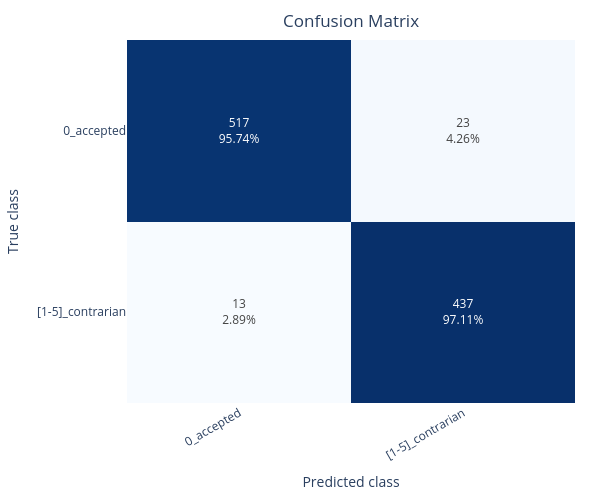

CARDS CLASSIFICATION REPORT

                         precision    recall  f1-score   support

             0_accepted       0.98      0.96      0.97       540
    1_its_not_happening       0.96      0.40      0.57       109
           2_its_not_us       0.77      0.94      0.85        80
          3_its_not_bad       0.74      0.93      0.83        72
  4_solutions_wont_work       0.89      0.91      0.90       119
5_science_is_unreliable       0.64      0.96      0.77        70

               accuracy                           0.89       990
              macro avg       0.83      0.85      0.81       990
           weighted avg       0.91      0.89      0.88       990



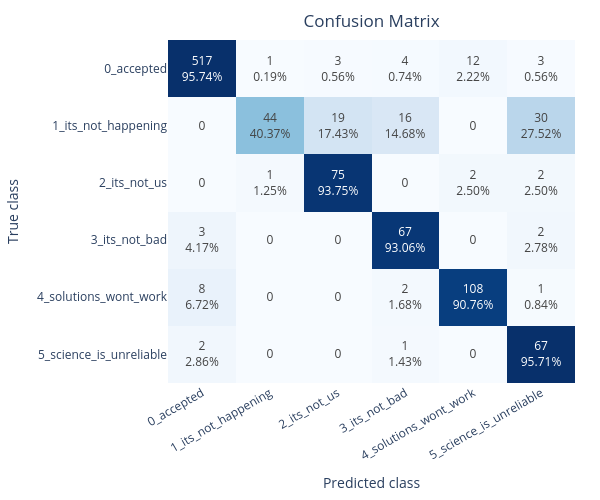

CLAIMS EXTRATION EVALUATION

BLEU: 0.91
ROUGE: 0.95


In [15]:
df = pd.read_csv("../../data/benchmark/mediatree_synthetic_sample_1000.csv")
await report_experiment_results(df, predict_cards_label)